In [30]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Path to your .dta file
file_path = "/Users/danielseymour/Downloads/all3.dta"

# Load the .dta file into a DataFrame
df = pd.read_stata(file_path)

# Display the first few rows
df.head()

,sales_u,pctacv,data,price,date,region,AVC_dist,AVC_adver
0,302306,98,ch,1.047743,1991-01-05,ch,966.872375,9742.702148
1,287260,98,ch,1.030878,1991-01-12,ch,958.782227,9595.088867
2,307435,98,ch,1.029291,1991-01-19,ch,952.054138,9640.892578
3,294160,98,ch,1.053824,1991-01-26,ch,953.193054,9598.753906
4,300197,98,ch,1.038931,1991-02-02,ch,928.393372,9599.876953


Columns explained:  
- sales_u: quantity sold
- pctacv: average cost of goods sold as percentage of price (?)
- data: {'ch': central hellmans , 'ck': central kraft , 'jh': jewel hellmans, 'jk': jewel kraft ]
- AVC_dist: Average Variable Cost of Distribution. Cost shifter
- AVC_adver: Average Variable Cost of Advertising. Demand shifter.

Notes:  
- Data and region are the same
- This is weekly data. 

In [7]:
df.describe()

,sales_u,pctacv,price,AVC_dist,AVC_adver
count,416.000000,416.000000,384.000000,416.000000,416.000000
mean,134445.644231,97.596154,1.095531,932.106812,9389.291016
std,145279.183583,4.764364,0.071565,143.639221,887.488831
min,0.000000,77.000000,0.494999,495.146240,5299.777832
25%,13750.750000,98.000000,1.065834,955.757187,9441.390137
50%,104740.000000,99.000000,1.112700,986.576508,9697.805664
75%,252974.250000,100.000000,1.138038,997.274445,9844.130615
max,643756.000000,100.000000,1.216236,999.985718,9999.769531


## Data Check

In [14]:
# Compute the mean prices across weeks of Hellman’s in Jewel and the Central Region. Are they
# comparable? Repeat the exercise for Kraft in Jewel and the Central Region.

# Calculate both mean and standard deviation for each unique value in the 'data' column
summary_prices = df.groupby('data')['price'].agg(['mean', 'std']).reset_index()
# Print the results
print(summary_prices)

# Remember zip only takes in tuples
price_dict = dict(zip(summary_prices['data'], zip(summary_prices['mean'], summary_prices['std'])))

# Access values
ch_mean, ch_std = price_dict.get('ch')
jh_mean, jh_std = price_dict.get('jh')
ck_mean, ck_std = price_dict.get('ck')
jk_mean, jk_std = price_dict.get('jk')

# Calculate percentage difference between Hellmans in the two regions (ch vs jh)
ch_jh_pct_diff = ((jh_mean - ch_mean) / ch_mean) * 100

# Calculate percentage difference between Kraft in the two regions (ck vs jk)
ck_jk_pct_diff = ((jk_mean - ck_mean) / ck_mean) * 100

# Print the results
print(f"Percentage difference between ch and jh: {ch_jh_pct_diff:.2f}%")
print(f"Percentage difference between ck and jk: {ck_jk_pct_diff:.2f}%")

  data      mean       std
0   ch  1.086778  0.036779
1   ck  1.088719  0.054266
2   jh  1.114487  0.066829
3   jk  1.094972  0.111722
Percentage difference between ch and jh: 2.55%
Percentage difference between ck and jk: 0.57%


- The prices between the same good across regions are comparable, but prices in the Jewel region are marginally higher. For Hellmans, prices in Jewel are 2.55% higher whereas for Kraft it's 0.57% higher.
- There is higher price variation in Jewel than in Central Region. This means estimates for the price elasticity will be more precise (lower standard errors) for Jewel due to the higher variation. In addition, a larger part of the demand curve will be estimated so there is greater ability to capture non-linear effects.

In [24]:
# Based on your headers: sales_u, pct, ac, v, price, AVC_dist, AVC_adver, data, date

# Group by date and data, calculating mean for prices and sum for sales
weekly_data = df.groupby(['date', 'data']).agg({
    'price': 'mean',  # Average price per date
    'sales_u': 'sum'  # Total sales per date
}).reset_index()

# Pivot the data to make plotting easier
price_pivot = weekly_data.pivot(index='date', columns='data', values='price')
sales_pivot = weekly_data.pivot(index='date', columns='data', values='sales_u')

print(price_pivot)

print(sales_pivot)

data              ch        ck        jh        jk
date                                              
1991-01-05  1.047743  1.035753       NaN       NaN
1991-01-12  1.030878  1.020164       NaN       NaN
1991-01-19  1.029291  0.985184       NaN       NaN
1991-01-26  1.053824  1.020728       NaN       NaN
1991-02-02  1.038931  1.027781       NaN       NaN
...              ...       ...       ...       ...
1992-11-28  1.113920  0.927696  1.163384  0.845022
1992-12-05  1.086931  1.108617  0.995001  1.175763
1992-12-12  1.105317  1.021443  0.995012  1.174027
1992-12-19  1.122189  0.998198  1.152144  0.745020
1992-12-26  1.126756  1.043191  1.157713  0.942142

[104 rows x 4 columns]
data            ch      ck     jh     jk
date                                    
1991-01-05  302306  124885      0      0
1991-01-12  287260  105285      0      0
1991-01-19  307435  138363      0      0
1991-01-26  294160  111494      0      0
1991-02-02  300197  110686      0      0
...            ...     ...

Construct scatter-plots of  sales versus prices for Kraft in both regions (i.e. prices on the Y-axis, unit-sales on the X-axis). Repeat the exercise for Kraft. Is there evidence for a negatively sloped demand-curve in the data? 

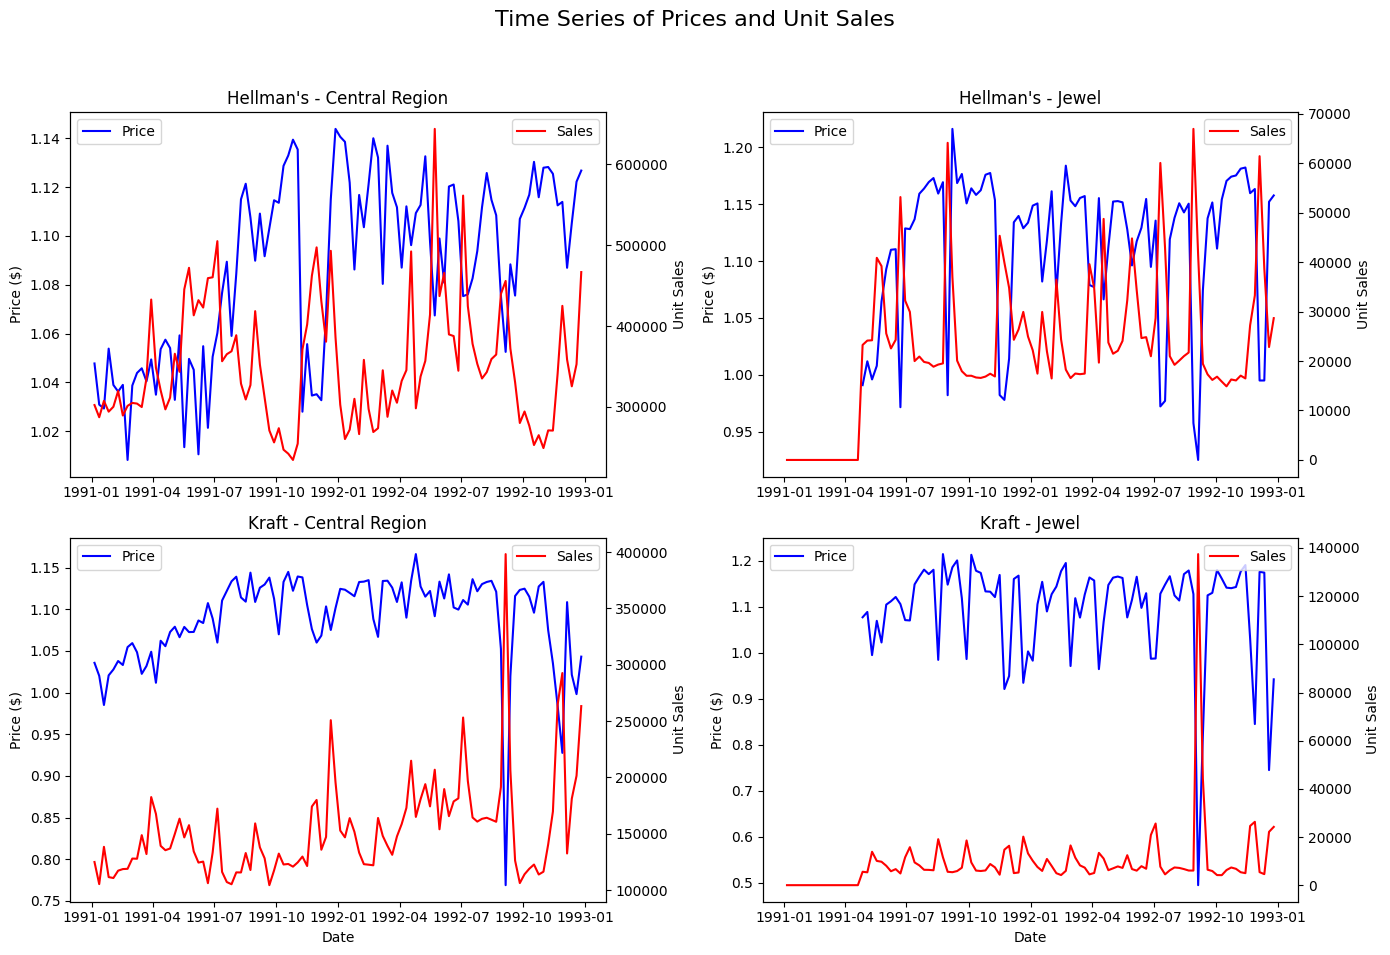

In [26]:
# Create a figure with 4 subplots (2 rows, 2 columns)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Time Series of Prices and Unit Sales', fontsize=16)

# Plot Hellman's data
# Central Hellman's
axes[0, 0].plot(price_pivot.index, price_pivot['ch'], 'b-', label='Price')
ax2 = axes[0, 0].twinx()
ax2.plot(sales_pivot.index, sales_pivot['ch'], 'r-', label='Sales')
axes[0, 0].set_title("Hellman's - Central Region")
axes[0, 0].set_ylabel('Price ($)')
ax2.set_ylabel('Unit Sales')
axes[0, 0].legend(loc='upper left')
ax2.legend(loc='upper right')

# Jewel Hellman's
axes[0, 1].plot(price_pivot.index, price_pivot['jh'], 'b-', label='Price')
ax2 = axes[0, 1].twinx()
ax2.plot(sales_pivot.index, sales_pivot['jh'], 'r-', label='Sales')
axes[0, 1].set_title("Hellman's - Jewel")
axes[0, 1].set_ylabel('Price ($)')
ax2.set_ylabel('Unit Sales')
axes[0, 1].legend(loc='upper left')
ax2.legend(loc='upper right')

# Plot Kraft data
# Central Kraft
axes[1, 0].plot(price_pivot.index, price_pivot['ck'], 'b-', label='Price')
ax2 = axes[1, 0].twinx()
ax2.plot(sales_pivot.index, sales_pivot['ck'], 'r-', label='Sales')
axes[1, 0].set_title("Kraft - Central Region")
axes[1, 0].set_xlabel('Date')
axes[1, 0].set_ylabel('Price ($)')
ax2.set_ylabel('Unit Sales')
axes[1, 0].legend(loc='upper left')
ax2.legend(loc='upper right')

# Jewel Kraft
axes[1, 1].plot(price_pivot.index, price_pivot['jk'], 'b-', label='Price')
ax2 = axes[1, 1].twinx()
ax2.plot(sales_pivot.index, sales_pivot['jk'], 'r-', label='Sales')
axes[1, 1].set_title("Kraft - Jewel")
axes[1, 1].set_xlabel('Date')
axes[1, 1].set_ylabel('Price ($)')
ax2.set_ylabel('Unit Sales')
axes[1, 1].legend(loc='upper left')
ax2.legend(loc='upper right')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout
plt.show()

Observations:  
- Kraft prices are stable apart from a single, sharp downwards spike in 1992.
- Hellman's prices have higher variance
- Sales units are responsive to prices as price decreases correspond to increases in sales, suggesting the goods have elastic demand

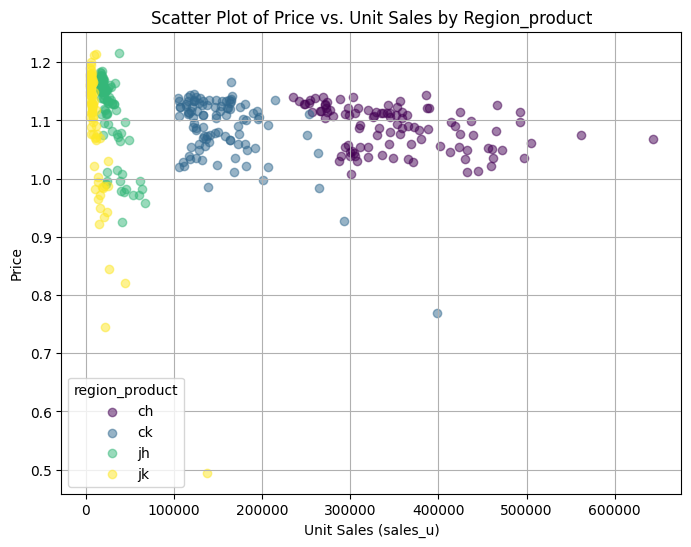

In [18]:
# Define unique regions
region_product = df["region"].unique()

# Generate distinct colors for each region
colors = plt.cm.viridis(np.linspace(0, 1, len(region_product)))  

# Create scatter plot for each region
plt.figure(figsize=(8, 6))
for i, region in enumerate(region_product):
    subset = df[df["region"] == region]
    plt.scatter(subset["sales_u"], subset["price"], alpha=0.5, label=region, color=colors[i])

# Labels, legend, and title
plt.xlabel("Unit Sales (sales_u)")
plt.ylabel("Price")
plt.title("Scatter Plot of Price vs. Unit Sales by Region_product")
plt.legend(title="region_product")
plt.grid(True)

# Show the plot
plt.show()

Observations:  
- There is strong evidence of a negatively sloped demand-curve in Jewel  
- The correlation is much weaker in Central Region 

# Demand Estimation

### Fit the "multiplicative" demand model discussed in class one for each region. Estimate the model with OLS and then use an IV. 

What is the typical “multiplicative” demand model?  
It's when you assume constant elasticity of demand in market m (i.e. the region) in week t: 
$$
\ln(Q_{mt}) = x_{mt}\beta - \alpha \ln(p_{mt}) + \varepsilon_{mt}
$$

where Q_m and p_m are respectively total quantity and price, x_m are demand shifters, and ε_m is the unobservable component.

It's multiplicative because:

$$
Q_{mt} = \exp\bigl(x_{mt}\beta - \alpha\ln(p_{mt}) + \varepsilon_{mt}\bigr)
= \exp(x_{mt}\beta)\,[p_{mt}]^{-\alpha}\,\exp(\varepsilon_{mt}).
$$

We will first estimate by OLS and then by IV in Python. We will assume a stylized demand model of the form

Questions:
- Should I include a time subscript too here? Yes, as there could be variations in demand based on time
- What should the instrument be? As we are estimating demand, we want to use as an instrument a cost shifter. 
- Therefore, we can use the distribution costs, AVC_dis, to produce variation in price (relevance) while it is exogeneous to demand shocks. For estimating supply curves, advertising would be a good demand shifter.

In [33]:
# Simple OLS of log quantity ~ log price 

# Assuming df contains your data with columns 'data', 'sales_u', 'price', etc.
# Filter data for Hellman's and Kraft at Jewel
hellmans_jewel = df[df['data'] == 'jh'].copy()
kraft_jewel = df[df['data'] == 'jk'].copy()

# Add log-transformed variables
for dataset in [hellmans_jewel, kraft_jewel]:
    dataset['log_sales'] = np.log(dataset['sales_u'])
    dataset['log_price'] = np.log(dataset['price'])
    # Add log-transformed advertising variable
    dataset['log_adver'] = np.log(dataset['AVC_adver'] + 1)  # Adding 1 to handle potential zero values

# Simple model with just own price
hellmans_model_simple = sm.OLS.from_formula('log_sales ~ log_price', data=hellmans_jewel)
hellmans_results_simple = hellmans_model_simple.fit()

kraft_model_simple = sm.OLS.from_formula('log_sales ~ log_price', data=kraft_jewel)
kraft_results_simple = kraft_model_simple.fit()

# Model with price and advertising
hellmans_model_adver = sm.OLS.from_formula('log_sales ~ log_price + log_adver', data=hellmans_jewel)
hellmans_results_adver = hellmans_model_adver.fit()

kraft_model_adver = sm.OLS.from_formula('log_sales ~ log_price + log_adver', data=kraft_jewel)
kraft_results_adver = kraft_model_adver.fit()

# Print the results
print("Hellman's at Jewel - Simple Model:")
print(hellmans_results_simple.summary())
print("\nKraft at Jewel - Simple Model:")
print(kraft_results_simple.summary())

print("\nHellman's at Jewel - Model with Advertising:")
print(hellmans_results_adver.summary())
print("\nKraft at Jewel - Model with Advertising:")
print(kraft_results_adver.summary())

Hellman's at Jewel - Simple Model:
                            OLS Regression Results                            
Dep. Variable:              log_sales   R-squared:                       0.573
Model:                            OLS   Adj. R-squared:                  0.568
Method:                 Least Squares   F-statistic:                     115.4
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           1.43e-17
Time:                        15:48:48   Log-Likelihood:                -1.2356
No. Observations:                  88   AIC:                             6.471
Df Residuals:                      86   BIC:                             11.43
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.

/Users/danielseymour/Developer/EC331-Thesis-Data/nem_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/danielseymour/Developer/EC331-Thesis-Data/nem_env/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Observations:
- Coefficients on prices are negative as per expectations
- Strangely, the coefficient on advertising is negative which doesn't align with theory.
- This pattern holds for both brands

Observations:
- Coefficients on prices are negative as per expectations
- Strangely, the coefficient on advertising is negative which doesn't align with theory.
- This pattern holds for both brands

In [ ]:
# Using distribution costs as an IV

Question 3:  
Forecasting demand under a price change: Using your regression results from the multiplicative demand model, compute the % change in unit sales for a 10% increase in the price of  Kraft.

What do we need?
- 